Test of the RedPitaya with QCodes drivers

In [1]:
import sys, os
import time

import numpy as np
from scipy.signal import periodogram, welch

import matplotlib.pyplot as plt
# plot options
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size=14)

In [2]:
# redpitaya drivers
sys.path.append(r'C:\Users\nicol\Progetti\Open Haloscope')
from red.redpitaya_qcodes import Redpitaya

<h4>Test of the drivers</h4>

In [3]:
ip_wlan = 'TCPIP::192.168.1.30::5000::SOCKET'
ip_eth0 = 'TCPIP::169.254.33.148::5000::SOCKET'
red = Redpitaya('redpitaya', address=ip_eth0)

Connected to: REDPITAYA INSTR2020 (serial:0, firmware:01-02) in 0.36s


In [7]:
red.temperature()

300.82

In [5]:
red.pressure()

1.1351300000000002

In [11]:
# start UART communication
red.UART_init()
red.UART_setup()

# the Aruino is configured to return the pressure when prompted with a 'p'
t = str( ord('t') )

# set the length of the message and send it, since it is a single letter the length is 1
red.UART_data_length(1)
red.UART_write(t)   

# set the length of the response, which is 7 bytes (e.g. 1023.51 = 7 characters) plus stop byte and new line
red.UART_data_length(7)
t_string = red.UART_read() 

# format the response into a number
t_string = t_string[1:-1].split(',')
t_string = list(map(int, t_string[0:5]))
t_string = "".join( list(map(chr, t_string)))

# pressure
t = float(t_string)
t

26.38

<h3>VNA</h3>

In [7]:
red.vna_start(4e6)
red.vna_stop(12e6)
red.vna_points(101)
red.vna_rbw(10e3)

red.vna_amplitude(0.1)
red.vna_averages(1)

In [8]:
mag, phase = red.VNA1()

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:26<00:00,  3.84it/s]


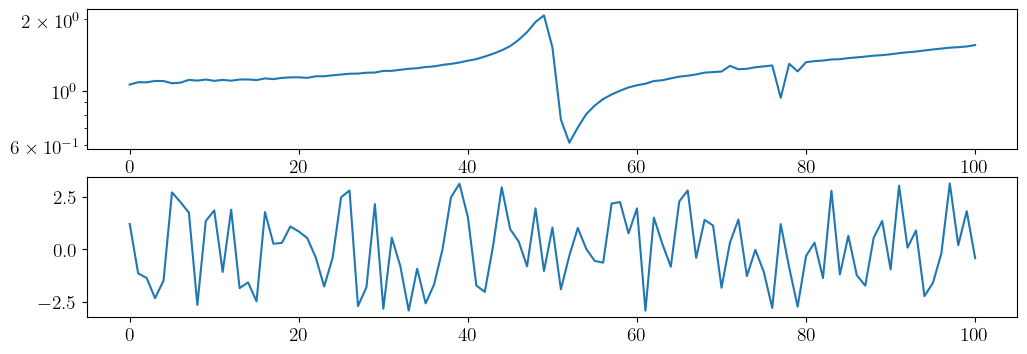

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(12,4))

ax[0].semilogy(mag)
ax[1].plot(phase)

<h3>Waveforms</h3>

In [10]:
# start the generators
red.align_channels_phase()
red.OUT_trigger()

In [11]:
# settings
# gen 1
red.OUT1_amplitude(0.1)
red.OUT1_frequency(2e6)
red.OUT1_status('ON')

# gen 2
red.OUT2_amplitude(0.1)
red.OUT2_frequency(2e6)
red.OUT2_status('OFF')

In [12]:
# adc
red.ADC_averaging('OFF')
red.ADC_decimation(4)

# trigger
red.ADC_trigger_level(0.0)

In [13]:
# adc parameters
fs = red.FS / red.ADC_decimation()

In [14]:
# problema con la lettura in binario
# se non c'è segnale non triggera?

In [15]:
# acquisition
red.acquisition_length(1)
data = red.IN1()

red.duty_cycle()

108it [00:01, 99.95it/s]                                                                                               


0.00524288

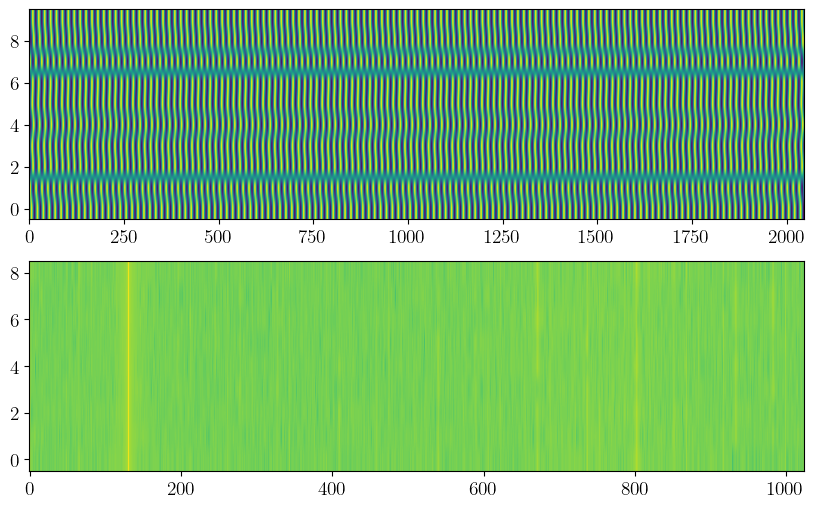

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
n_start = 1
n_stop = 2**11

ax[0].imshow( data[:,n_start:n_stop], aspect='auto', origin='lower' )
ax[1].imshow( np.log10(periodogram( data[:,n_start:n_stop] )[1][1:]), aspect='auto', origin='lower' )

#ax[1].set_ylim([1e-8,1])

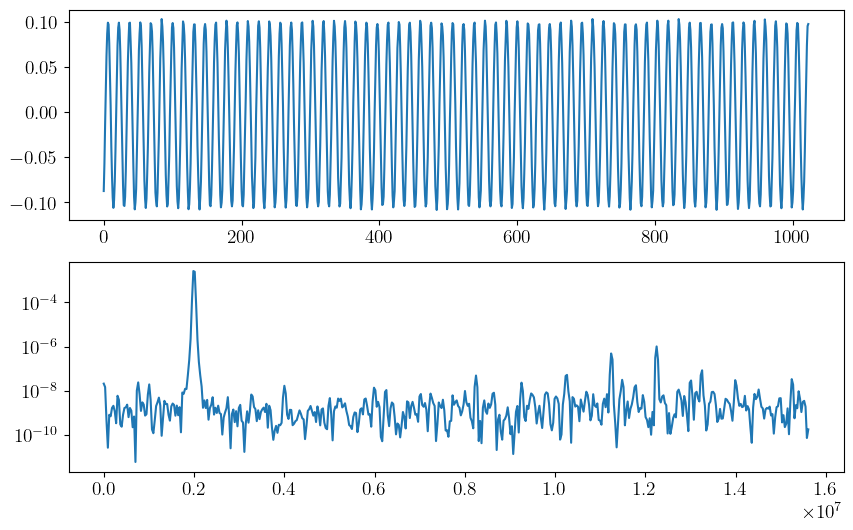

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
n_start = 1
n_stop = 2**10
num = 0

ax[0].plot(data[num, n_start:n_stop])

f = periodogram(data[num, n_start:n_stop], fs=fs)[0]
rbw = f[1] - f[0]
m = rbw * periodogram(data[num, n_start:n_stop], window='hann', fs=fs)[1]
ax[1].semilogy(f, m)

In [18]:
red.estimated_duty_cycle()

0.00524288